# Analysis of Wind Turbine Data with Generalized Additive Models for Location, Scale, and Shape (R Package Gamlss)

1. [Libraries and external scripts.](#Cell1)
1. [Load the data frame.](#Cell2)
1. [Add columns with horizontal wind velocity magnitudes and remove columns with velocity components.](#Cell3)
1. [Examine autocorrelations in turbine output measurements.](#Cell4)
1. [Create new data frames, one per turbine output; split each data frame into a training and a testing data frame.](#Cell5)
1. [Fit training data frames.](#Cell6)
1. [Fit training data frames, this time eliminating predictors that are not significant.](#Cell7)
1. [Compute root mean squared errors on training and testing data sets.](#Cell8)
1. [Print summary of fit results by turbine.](#Cell9)
1. [Make a QQ plot.](#Cell10)
1. [Fit entire training data set.](#Cell13)
1. [Fit entire training data set, this time eliminating predictors that are not significant.](#Cell14)
1. [Prepare the test data set in the same way as the training set, make predictions, and create output csv file.](#Cell15)
1. [Compute weekly RMSE, save to file and make a plot.](#Cell16)

<a id='Cell1'></a>

In [1]:
# Libraries and external scripts.

library("dplyr")
library("feather")
library("gamlss")
library("scales")
source("summarynoprint.R")
source("wp_withdata.R")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: splines
Loading required package: gamlss.data
Loading required package: gamlss.dist
Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: parallel
 **********   GAMLSS Version 5.0-1  ********** 
For more on GAMLSS look at http://www.gamlss.org/
Type gamlssNews() to see new features/changes/bug fixes.



<a id='Cell2'></a>

In [2]:
# Load the data frame.
# First set the rolling mean window size, the number of turbines, and the non-duplicate wind measurements.
rmws <- 3
nturbines <- 10
wind_measurements <- c(1, 2, 3, 4, 6, 7, 9, 10)

if (rmws == 3) {
    df <- read_feather(path="data/Train_pp_2017_03_27_17_46_01.feather")
    rm <- "_rm3_"
} else if (rmws <= 1) {
    df <- read_feather(path="data/Train_pp_2017_03_27_17_47_52.feather")
    rm <- "_"
}
head(df)
cat("\nData frame dimensions: ", dim(df)[1], " rows, ", dim(df)[2], " columns", sep="")

Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”

TARGETVAR_1,TARGETVAR_2,TARGETVAR_3,TARGETVAR_4,TARGETVAR_5,TARGETVAR_6,TARGETVAR_7,TARGETVAR_8,TARGETVAR_9,TARGETVAR_10,⋯,U100_rm3_9,V10_rm3_9,V100_rm3_9,U10_rm3_10,U100_rm3_10,V10_rm3_10,V100_rm3_10,YEAR,DAYOFYEAR,HOUR
0.00000000,0.59627269,0.42546509,0.378229364,0.273678157,0.268101299,0.00000000,0.00000000,0,0.5943608,⋯,2.516723,-1.49500174,-2.0780630,1.655790,2.024257,-4.649593,-5.992232,2012,1,1
0.05487912,0.41118016,0.36385087,0.063011972,0.086795946,0.034542253,0.01470814,0.01495395,0,0.5696790,⋯,2.676916,-1.06932139,-1.5424883,1.917199,2.323699,-4.417269,-5.655159,2012,1,2
0.11023400,0.16724280,0.29712869,0.036704474,0.006811401,0.020621359,0.03509778,0.07178487,0,0.3305387,⋯,2.795976,-0.66734909,-1.0334890,2.021010,2.430872,-4.025660,-5.120850,2012,1,3
0.16511606,0.03732617,0.23543795,0.034341525,0.018645987,0.001867149,0.04505471,0.06679646,0,0.2113084,⋯,2.937678,0.09670349,-0.0662909,2.161491,2.567102,-3.257490,-4.094716,2012,1,4
0.15694013,0.05120634,0.12090357,0.033553875,0.034811833,0.015173538,0.05015951,0.03479741,0,0.1721397,⋯,2.845034,0.73980237,0.7597144,2.040194,2.392003,-2.388384,-2.980721,2012,1,5
0.16878113,0.04214444,0.07195258,0.009451796,0.021916897,0.012904598,0.05249198,0.02323503,0,0.1513545,⋯,2.428796,1.43571202,1.6873206,1.776940,2.050484,-1.649743,-2.065589,2012,1,6



Data frame dimensions: 13871 rows, 45 columns

<a id='Cell3'></a>


Data frame dimensions: 13871 rows, 29 columns

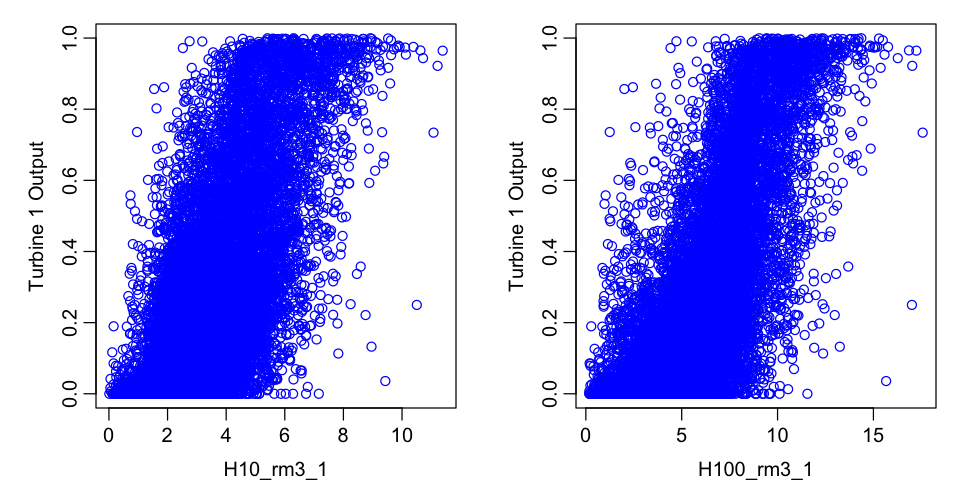

In [3]:
# Add columns with horizontal wind velocity magnitudes.
# Remove columns with velocity components.
# Keep only every iskip'th row (to reduce response variable autocorrelation).

iskip <- 1

U10label  <- paste(paste("U10",  rm, sep=""), 1:nturbines, sep="")
U100label <- paste(paste("U100", rm, sep=""), 1:nturbines, sep="")
V10label  <- paste(paste("V10",  rm, sep=""), 1:nturbines, sep="")
V100label <- paste(paste("V100", rm, sep=""), 1:nturbines, sep="")
H10label  <- paste(paste("H10",  rm, sep=""), 1:nturbines, sep="")
H100label <- paste(paste("H100", rm, sep=""), 1:nturbines, sep="")
for (i in wind_measurements) {
    df[[H10label[i]]]  <- sqrt(df[[U10label[i]]]**2  + df[[V10label[i]]]**2)
    df[[H100label[i]]] <- sqrt(df[[U100label[i]]]**2 + df[[V100label[i]]]**2)
    df[[U10label[i]]]  <- NULL
    df[[U100label[i]]] <- NULL
    df[[V10label[i]]]  <- NULL
    df[[V100label[i]]] <- NULL
}
df <- df[seq(iskip, to=nrow(df), by=iskip), ]
cat("\nData frame dimensions: ", dim(df)[1], " rows, ", dim(df)[2], " columns", sep="")
options(repr.plot.width=8, repr.plot.height=4)
par(mgp=c(2, 0.6, 0), mar=c(3,4,1,1), mfrow=c(1, 2))
plot(TARGETVAR_1 ~ df[[H10label[1]]],  data=df, col="blue", xlab=H10label[1],  ylab="Turbine 1 Output")
plot(TARGETVAR_1 ~ df[[H100label[1]]], data=df, col="blue", xlab=H100label[1], ylab="Turbine 1 Output")

<a id='Cell4'></a>


Autocorrelation in turbine outputs:  0.9427811
Correlation between turbine output and wind speed:  0.6942137

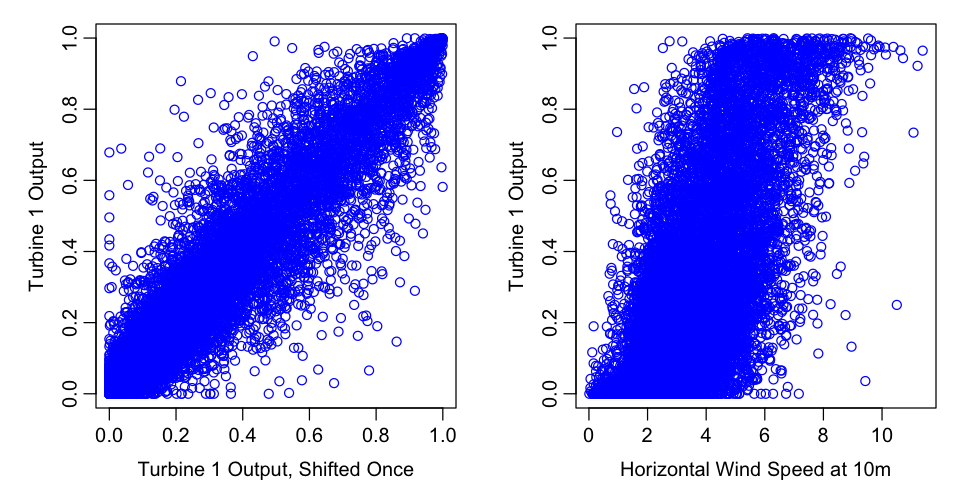

In [4]:
# Examine autocorrelations in turbine 1 output measurements.

shift.down <- function(x, n) {c(x[-(seq(n))], rep(NA, n))}

dfc <- data.frame(TARGETVAR_1=df$TARGETVAR_1, TARGETVAR_1S=df$TARGETVAR_1, H10=df[[H10label[1]]])
dfc$TARGETVAR_1S <- shift.down(dfc$TARGETVAR_1S, 1)

options(repr.plot.width=8, repr.plot.height=4)
par(mgp=c(2, 0.6, 0), mar=c(3,4,1,1), mfrow=c(1, 2))
plot(TARGETVAR_1 ~ TARGETVAR_1S, data=dfc, col="blue", 
     xlab="Turbine 1 Output, Shifted Once", ylab="Turbine 1 Output")
plot(TARGETVAR_1 ~ H10, data=dfc, col="blue", 
     xlab="Horizontal Wind Speed at 10m", ylab="Turbine 1 Output")

cat("\nAutocorrelation in turbine outputs: ", 
    cor(dfc$TARGETVAR_1, dfc$TARGETVAR_1S, use="pairwise.complete.obs"))
cat("\nCorrelation between turbine output and wind speed: ", 
    cor(dfc$TARGETVAR_1, dfc$H10, use="pairwise.complete.obs"))

<a id='Cell5'></a>

In [5]:
# Create new data frames, one per turbine output;
# If desired, remove rows where the turbine output is 0 and/or 1;
# Split each data frame into a training and a testing data frame.

remove0 <- FALSE
remove1 <- FALSE

predictors <- colnames(df)[-c(1:10)]
fdf        <- vector("list", nturbines)
fdf_train  <- vector("list", nturbines)
fdf_test   <- vector("list", nturbines)
for (i in 1:nturbines) {
    target         <- paste("TARGETVAR_", i, sep="")
    fdf[[i]]       <- df[, c(target,predictors)]
    nrows0         <- nrow(fdf[[i]][fdf[[i]][[target]]==0,])
    nrows1         <- nrow(fdf[[i]][fdf[[i]][[target]]==1,])
    if (remove0) fdf[[i]] <- fdf[[i]][fdf[[i]][[target]]!=0,]
    if (remove1) fdf[[i]] <- fdf[[i]][fdf[[i]][[target]]!=1,]
    set.seed(7)
    indices        <- sample(1:nrow(fdf[[i]]), size=0.30*nrow(fdf[[i]]))
    fdf_test[[i]]  <- fdf[[i]][indices,]
    fdf_train[[i]] <- fdf[[i]][-indices,]
    nrows0ts       <- nrow(fdf_test[[i]][fdf_test[[i]][[target]]==0,])
    nrows1ts       <- nrow(fdf_test[[i]][fdf_test[[i]][[target]]==1,])
    nrows0tr       <- nrow(fdf_train[[i]][fdf_train[[i]][[target]]==0,])
    nrows1tr       <- nrow(fdf_train[[i]][fdf_train[[i]][[target]]==1,])
    cat(sprintf("\nData frame %2d: (%5d, %2d, %4d, %1d);",i,dim(fdf[[i]])[1],dim(fdf[[i]])[2],nrows0,nrows1))
    cat(sprintf("  train: (%5d, %2d, %4d, %1d);",dim(fdf_train[[i]])[1],dim(fdf_train[[i]])[2],nrows0tr,nrows1tr))
    cat(sprintf("  test: (%5d, %2d, %4d, %1d).",dim(fdf_test[[i]])[1],dim(fdf_test[[i]])[2],nrows0ts,nrows1ts))
}
cat("\n\nLegend: (nrows, ncolumns, nrows(target==0), nrows(target==1))")
names(fdf)       <- paste("fdf", 1:nturbines, sep="")
names(fdf_train) <- paste("fdf", 1:nturbines, sep="")
names(fdf_test)  <- paste("fdf", 1:nturbines, sep="")


Data frame  1: (13871, 20, 1381, 0);  train: ( 9710, 20,  970, 0);  test: ( 4161, 20,  411, 0).
Data frame  2: (13871, 20,  337, 1);  train: ( 9710, 20,  233, 1);  test: ( 4161, 20,  104, 0).
Data frame  3: (13871, 20,  886, 0);  train: ( 9710, 20,  605, 0);  test: ( 4161, 20,  281, 0).
Data frame  4: (13871, 20,  628, 2);  train: ( 9710, 20,  447, 1);  test: ( 4161, 20,  181, 1).
Data frame  5: (13871, 20, 1107, 1);  train: ( 9710, 20,  810, 1);  test: ( 4161, 20,  297, 0).
Data frame  6: (13871, 20, 1110, 1);  train: ( 9710, 20,  786, 1);  test: ( 4161, 20,  324, 0).
Data frame  7: (13871, 20, 1222, 0);  train: ( 9710, 20,  855, 0);  test: ( 4161, 20,  367, 0).
Data frame  8: (13871, 20, 1562, 0);  train: ( 9710, 20, 1104, 0);  test: ( 4161, 20,  458, 0).
Data frame  9: (13871, 20, 2361, 1);  train: ( 9710, 20, 1645, 1);  test: ( 4161, 20,  716, 0).
Data frame 10: (13871, 20, 1140, 1);  train: ( 9710, 20,  803, 0);  test: ( 4161, 20,  337, 1).

Legend: (nrows, ncolumns, nrows(target

<a id='Cell6'></a>

In [6]:
# Fit training data frames.
# This version does not check which predictors are significant.

linear_predictor <- paste(H10label[wind_measurements], H100label[wind_measurements], sep=" + ", collapse=" + " )
wtp              <- vector("list", nturbines)
ptm              <- proc.time()
for (i in 1:nturbines) {
    target   <- paste("TARGETVAR_", i, sep="")
    cat("\nNow fitting ", target, "\n", sep="")
    fmla     <- as.formula(paste(target, " ~ ", linear_predictor, sep=""))
    nu.fmla  <- as.formula(paste(" ~ ", linear_predictor, sep=""))
    wtp[[i]] <- gamlss(fmla, nu.formula=nu.fmla, data=fdf_train[[i]], 
                       family=BEINF(mu.link="logit"), method=mixed(), trace=TRUE)
#    wtp[[i]] <- gamlss(fmla, data=fdf_train[[i]], family=BEINF(mu.link="logit"), method=mixed(), trace=TRUE)
}
timings          <- proc.time()-ptm
cat("\nTimings: User = ", timings[1],", System = ", timings[2], ", Elapsed = ", timings[3], sep="")


Now fitting TARGETVAR_1
GAMLSS-RS iteration 1: Global Deviance = -8905.177 
GAMLSS-CG iteration 1: Global Deviance = -9832.019 
GAMLSS-CG iteration 2: Global Deviance = -9916.092 
GAMLSS-CG iteration 3: Global Deviance = -9917.491 
GAMLSS-CG iteration 4: Global Deviance = -9917.513 
GAMLSS-CG iteration 5: Global Deviance = -9917.513 

Now fitting TARGETVAR_2
GAMLSS-RS iteration 1: Global Deviance = -10823.05 
GAMLSS-CG iteration 1: Global Deviance = -11737.13 
GAMLSS-CG iteration 2: Global Deviance = -11820.65 
GAMLSS-CG iteration 3: Global Deviance = -11822.89 
GAMLSS-CG iteration 4: Global Deviance = -11822.98 
GAMLSS-CG iteration 5: Global Deviance = -11822.98 
GAMLSS-CG iteration 6: Global Deviance = -11822.98 

Now fitting TARGETVAR_3
GAMLSS-RS iteration 1: Global Deviance = -7911.568 
GAMLSS-CG iteration 1: Global Deviance = -8519.605 
GAMLSS-CG iteration 2: Global Deviance = -8551.956 
GAMLSS-CG iteration 3: Global Deviance = -8552.242 
GAMLSS-CG iteration 4: Global Deviance = 

<a id='Cell7'></a>

In [6]:
# Fit training data frames.
# This version checks for predictors that are not significant and eliminates them one by one.

ptm <- proc.time()
wtp <- vector("list", nturbines)
for (i in 1:nturbines) {
    all_predictors <- c(H10label[wind_measurements], H100label[wind_measurements])
    target         <- paste("TARGETVAR_", i, sep="")
    more           <- TRUE
    while (more) {
        linear_predictor <- paste(all_predictors, sep=" + ", collapse=" + " )        
        fmla             <- as.formula(paste(target, " ~ ", linear_predictor, sep=""))
        nu.fmla          <- as.formula(paste(" ~ ", linear_predictor, sep=""))
        wtp[[i]]         <- gamlss(fmla, nu.formula=nu.fmla, data=fdf_train[[i]], 
                                   family=BEINF(mu.link="logit"), method=mixed(), trace=FALSE)
        swtp             <- summarynoprint.gamlss(wtp[[i]])
        deviance0        <- wtp[[i]]$G.deviance
        all_predictors   <- names(swtp$mu.coef.table[,4])
        all_predictors   <- all_predictors[all_predictors != "(Intercept)"]
        
        # Make a list of "bad" predictors, i.e. predictors with a p-value>5% in the mu fit.
        n_bad_predictors <- 0
        bad_predictors   <- vector("integer", length(all_predictors))
        for (name in all_predictors) {
            if (swtp$mu.coef.table[,4][[name]] >= 0.05) {
                n_bad_predictors                 <- n_bad_predictors + 1
                bad_predictors[n_bad_predictors] <- name
            }
        }
        
        # Loop over all bad predictors, find the one whose removal results in the smallest change in deviance.
        if (n_bad_predictors == 0) {
            more <- FALSE
        } else {
            delta_deviances  <- vector("double", n_bad_predictors)
            for (j in 1:n_bad_predictors) {
                new_predictors     <- all_predictors[all_predictors != bad_predictors[j]]
                linear_predictor   <- paste(new_predictors, sep=" + ", collapse=" + " )        
                fmla               <- as.formula(paste(target, " ~ ", linear_predictor, sep=""))
                wtp[[i]]           <- gamlss(fmla, nu.formula=nu.fmla, data=fdf_train[[i]], 
                                             family=BEINF(mu.link="logit"), method=mixed(), trace=FALSE)
                delta_deviances[j] <- wtp[[i]]$G.deviance - deviance0
            }
            index_sm_dev   <- which.min(delta_deviances)
            all_predictors <- all_predictors[all_predictors != bad_predictors[index_sm_dev]]
            if (length(all_predictors) == 0) {more <- FALSE}
        }
    }
    cat("\nTurbine ", i, ": Number of predictors = ", length(all_predictors), ", deviance = ", deviance0, sep="")
    cat("\n           Predictors:", all_predictors, "\n", sep=" ")
}
timings <- proc.time()-ptm
cat("\nTimings: User = ", timings[1],", System = ", timings[2], ", Elapsed = ", timings[3], sep="")


Turbine 1: Number of predictors = 11, deviance = -13782.25
           Predictors: H10_2 H10_3 H10_7 H10_10 H100_1 H100_3 H100_4 H100_6 H100_7 H100_9 H100_10 

Turbine 2: Number of predictors = 10, deviance = -13398.55
           Predictors: H10_2 H10_3 H10_4 H10_6 H100_1 H100_2 H100_3 H100_6 H100_9 H100_10 

Turbine 3: Number of predictors = 12, deviance = -10623.86
           Predictors: H10_1 H10_2 H10_3 H10_6 H10_9 H100_1 H100_2 H100_3 H100_6 H100_7 H100_9 H100_10 

Turbine 4: Number of predictors = 10, deviance = -14913.46
           Predictors: H10_2 H10_4 H10_9 H10_10 H100_1 H100_3 H100_4 H100_6 H100_9 H100_10 

Turbine 5: Number of predictors = 9, deviance = -9982.16
           Predictors: H10_1 H10_2 H10_4 H10_10 H100_2 H100_3 H100_4 H100_6 H100_10 

Turbine 6: Number of predictors = 12, deviance = -9755.178
           Predictors: H10_1 H10_2 H10_3 H10_4 H10_6 H10_10 H100_2 H100_3 H100_4 H100_6 H100_9 H100_10 

Turbine 7: Number of predictors = 10, deviance = -12901.13
       

<a id='Cell8'></a>

In [23]:
# Compute root mean squared errors on training and testing data sets.

rmse_train <- vector("double", nturbines)
rmse_test  <- vector("double", nturbines)
for (i in 1:nturbines) {
    target         <- paste("TARGETVAR_", i, sep="")
    mu_train_pred  <- predict(wtp[[i]], what="mu",  newdata=NULL, type="response")
    nu_train_pred  <- predict(wtp[[i]], what="nu",  newdata=NULL, type="response")
    tau_train_pred <- predict(wtp[[i]], what="tau", newdata=NULL, type="response")
    p0_train       <- nu_train_pred/(1+nu_train_pred+tau_train_pred)
    p1_train       <- tau_train_pred/(1+nu_train_pred+tau_train_pred)
    p2_train       <- 1 - p0_train - p1_train
    y_train_exp    <- p1_train + p2_train * mu_train_pred
    y_train_pred   <- ifelse(p0_train>1.0, 0, y_train_exp) # Try thresholding on p0
    y_train_true   <- fdf_train[[i]][[target]]
    rmse_train[i]  <- sum((y_train_pred-y_train_true)^2)/nrow(fdf_train[[i]])
    
    mu_test_pred   <- predict(wtp[[i]], what="mu",  newdata=fdf_test[[i]], type="response")
    nu_test_pred   <- predict(wtp[[i]], what="nu",  newdata=fdf_test[[i]], type="response")
    tau_test_pred  <- predict(wtp[[i]], what="tau", newdata=fdf_test[[i]], type="response")
    p0_test        <- nu_test_pred/(1+nu_test_pred+tau_test_pred)
    p1_test        <- tau_test_pred/(1+nu_test_pred+tau_test_pred)
    p2_test        <- 1 - p0_test - p1_test
    y_test_exp     <- p1_test + p2_test * mu_test_pred
    y_test_pred    <- ifelse(p0_test>1.0, 0, y_test_exp) # Try thresholding on p0
    y_test_true    <- fdf_test[[i]][[target]]
    rmse_test[i]   <- sum((y_test_pred-y_test_true)^2)/nrow(fdf_test[[i]])
}
cat("\nRoot mean square errors on training data set:")
cat("\nBy turbine: ", sqrt(rmse_train), sep=" ")
cat("\nTotal: ", sqrt(sum(rmse_train)/nturbines))
cat("\n\nRoot mean square errors on testing data set:")
cat("\nBy turbine: ", sqrt(rmse_test), sep=" ")
cat("\nTotal: ", sqrt(sum(rmse_test)/nturbines))


Root mean square errors on training data set:
By turbine:  0.1392375 0.1459307 0.1561004 0.1718262 0.169001 0.1773336 0.137581 0.1613609 0.1612718 0.1932796
Total:  0.1621464

Root mean square errors on testing data set:
By turbine:  0.1371115 0.1472433 0.1563231 0.1713912 0.1684271 0.175808 0.13665 0.1610964 0.1622692 0.1882233
Total:  0.1612305

<a id='Cell9'></a>

In [8]:
# Print summary of fit results by turbine.

sumwtp <- summary(wtp[[6]], save=TRUE)

Warning message in summary.gamlss(wtp[[6]], save = TRUE):
“summary: vcov has failed, option qr is used instead
”

******************************************************************
Family:  c("BEINF", "Beta Inflated") 

Call:  
gamlss(formula = fmla, nu.formula = nu.fmla, family = BEINF(mu.link = "logit"),  
    data = fdf_train[[i]], method = mixed(), trace = TRUE) 

Fitting method: mixed() 

------------------------------------------------------------------
Mu link function:  logit
Mu Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -3.929272   0.033776 -116.334  < 2e-16 ***
H10_rm3_1    0.091072   0.048216    1.889 0.058944 .  
H100_rm3_1   0.090652   0.032103    2.824 0.004756 ** 
H10_rm3_2   -0.066520   0.034114   -1.950 0.051213 .  
H100_rm3_2   0.077781   0.023013    3.380 0.000728 ***
H10_rm3_3   -0.076656   0.029371   -2.610 0.009071 ** 
H100_rm3_3   0.069154   0.019610    3.527 0.000423 ***
H10_rm3_4    0.146931   0.053930    2.724 0.006452 ** 
H100_rm3_4   0.123113   0.040996    3.003 0.002680 ** 
H10_rm3_6   -0.268312   0.063074   -4.254 2.12e-05 ***
H10

<a id='Cell10'></a>

In [50]:
# Calculate nu predicted in two ways to check understanding.

turbine             <- 6
instance            <- 4

nu_coeff            <- as.vector(wtp[[turbine]]$nu.coefficients)
xval                <- c(1.0, as.vector(t(fdf_train[[turbine]][instance, 5:20])))
nu_linear_predictor <- (nu_coeff %*% xval)[1, 1]
nu_predicted1       <- exp(nu_linear_predictor)
print(nu_predicted1)

nu_predicted2       <- predict(wtp[[turbine]], what="nu", newdata=NULL, type="response")
print(nu_predicted2[instance])

[1] 0.9105504
        4 
0.9105504 


In [38]:
# Compute turbine output predictions and QQ plot components 
# for training (testdf=FALSE) and testing (testdf=TRUE) data sets.
# Combine data from all ten turbines.

testdf <- FALSE

if (testdf) { 
    nrows_all <- Reduce("+", lapply(fdf_test, nrow))
} else {
    nrows_all <- Reduce("+", lapply(fdf_train, nrow))
}
y_predicted_all        <- vector("double", nrows_all)
y_observed_all         <- vector("double", nrows_all)
quantile_residuals_all <- vector("double", nrows_all)
ind1                   <- 1
for (i in 1:nturbines) {
    if (testdf) {
        nrows              <- nrow(fdf_test[[i]])
    } else {
        nrows              <- nrow(fdf_train[[i]])
    }
    ind2                   <- ind1 + nrows - 1
    target                 <- paste("TARGETVAR_", i, sep="")
    if (testdf) {
        y_observed         <- fdf_test[[i]][[target]]
        mu_predicted       <- predict(wtp[[i]], what="mu",    newdata=fdf_test[[i]], type="response")
        sigma_predicted    <- predict(wtp[[i]], what="sigma", newdata=fdf_test[[i]], type="response")
        nu_predicted       <- predict(wtp[[i]], what="nu",    newdata=fdf_test[[i]], type="response")
        tau_predicted      <- predict(wtp[[i]], what="tau",   newdata=fdf_test[[i]], type="response")
    } else {
        y_observed         <- fdf_train[[i]][[target]]
        mu_predicted       <- predict(wtp[[i]], what="mu",    newdata=NULL, type="response")
        sigma_predicted    <- predict(wtp[[i]], what="sigma", newdata=NULL, type="response")
        nu_predicted       <- predict(wtp[[i]], what="nu",    newdata=NULL, type="response")
        tau_predicted      <- predict(wtp[[i]], what="tau",   newdata=NULL, type="response")
    }
    p0_predicted           <- nu_predicted/(1+nu_predicted+tau_predicted)
    p1_predicted           <- tau_predicted/(1+nu_predicted+tau_predicted)
    p2_predicted           <- 1 - p0_predicted - p1_predicted
    y_predicted            <- p1_predicted + p2_predicted * mu_predicted
    beta_lower_tail        <- pBEINF(y_observed, mu=mu_predicted, sigma=sigma_predicted, 
                                     nu=nu_predicted, tau=tau_predicted, lower.tail=TRUE, log.p=FALSE)
    quantile_residuals     <- qnorm(beta_lower_tail)
    y_predicted_all[ind1:ind2]        <- y_predicted
    y_observed_all[ind1:ind2]         <- y_observed
    quantile_residuals_all[ind1:ind2] <- quantile_residuals
    ind1                              <- ind2 + 1
}

sorted_residuals_all   <- sort.list(quantile_residuals_all, decreasing=FALSE)
normal_quantiles_all   <- vector("double", nrows_all)
normal_quantiles_all[sorted_residuals_all] <- qnorm(seq(1,nrows_all)/(nrows_all+1))

In [40]:
# Make QQ plot and turbine output histogram from data computed in previous cell.
# Set save_to_file to TRUE to save plots to file.

save_to_file <- TRUE

color1t  <- alpha("green", 0.3)
color2t  <- alpha("blue", 0.3)
color3t  <- alpha("red", 0.3)
color1   <- alpha("green", 1.0)
color2   <- alpha("blue", 1.0)
color3   <- alpha("red", 1.0)
x_limits <- c(max(min(normal_quantiles_all),-4), min(max(normal_quantiles_all),4))
y_limits <- c(max(min(quantile_residuals_all),-4), min(max(quantile_residuals_all),4))

if (save_to_file) {
    if (testdf) {
        fname <- "wind_turbine_output_test_gamlss.png"
    } else {
        fname <- "wind_turbine_output_train_gamlss.png"
    }
    png(file=fname, width=1200, height=400)
}
options(repr.plot.width=12, repr.plot.height=4)
par(mgp=c(2, 0.6, 0), mar=c(5,6,3,1))
layout(matrix(c(1,1,2), 1, 3))

break_points <- seq(0.0, 1.0, by=0.01)
hist(y_observed_all, breaks=break_points, col=color1t, main="", xlab="Turbine Output", ylab="", 
     cex.lab=2, cex.axis=2, mgp=c(3.5,1.5,0), yaxs="i", las=1)
hist(y_predicted_all, breaks=break_points, col=color2t, main="", xlab="", ylab="", add=TRUE)
legend("topright", c("predicted", "actual"), fill=c(color2t, color1t), cex=2, y.intersp=2)
if (testdf) {
    text(0.1, 4500., "Testing Subset", cex=2, pos=4)
} else {
    text(0.1, 11000., "Training Subset", cex=2, pos=4)
}
box(which="plot", lty="solid")

plot(quantile_residuals_all ~ normal_quantiles_all, 
     xlim=x_limits, ylim=y_limits, col=color2t, 
     xlab="Normal Quantiles", ylab="Quantile Residuals", cex.lab=2, cex.axis=2, mgp=c(3.5,1.5,0), las=1)
abline(a=0, b=1, col="black")

if (save_to_file) {
    dev.off()
}

pdf 
  2

<a id='Cell13'></a>

In [9]:
# Fit entire training set.

ptm               <- proc.time()
linear_predictor  <- paste(H10label[wind_measurements], H100label[wind_measurements], sep=" + ", collapse=" + " )
wtp_full          <- vector("list", nturbines)
for (i in 1:nturbines) {
    target        <- paste("TARGETVAR_", i, sep="")
    cat("\nNow fitting ", target, "\n", sep="")
    fmla          <- as.formula(paste(target, " ~ ", linear_predictor, sep=""))
    nu.fmla       <- as.formula(paste(" ~ ", linear_predictor, sep=""))
    wtp_full[[i]] <- gamlss(fmla, nu.formula=nu.fmla, data=fdf[[i]], 
                            family=BEINF(mu.link="logit"), method=mixed(), trace=TRUE)
}
timings <- proc.time()-ptm
cat("\nTimings: User = ", timings[1],", System = ", timings[2], ", Elapsed = ", timings[3], sep="")


Now fitting TARGETVAR_1
GAMLSS-RS iteration 1: Global Deviance = -13050.41 
GAMLSS-CG iteration 1: Global Deviance = -14398.76 
GAMLSS-CG iteration 2: Global Deviance = -14521.49 
GAMLSS-CG iteration 3: Global Deviance = -14523.46 
GAMLSS-CG iteration 4: Global Deviance = -14523.49 
GAMLSS-CG iteration 5: Global Deviance = -14523.49 

Now fitting TARGETVAR_2
GAMLSS-RS iteration 1: Global Deviance = -15432.29 
GAMLSS-CG iteration 1: Global Deviance = -16697.98 
GAMLSS-CG iteration 2: Global Deviance = -16808.71 
GAMLSS-CG iteration 3: Global Deviance = -16811.49 
GAMLSS-CG iteration 4: Global Deviance = -16811.59 
GAMLSS-CG iteration 5: Global Deviance = -16811.6 
GAMLSS-CG iteration 6: Global Deviance = -16811.6 

Now fitting TARGETVAR_3
GAMLSS-RS iteration 1: Global Deviance = -11169.79 
GAMLSS-CG iteration 1: Global Deviance = -12037.79 
GAMLSS-CG iteration 2: Global Deviance = -12083.88 
GAMLSS-CG iteration 3: Global Deviance = -12084.27 
GAMLSS-CG iteration 4: Global Deviance = -1

<a id='Cell14'></a>

In [7]:
# Fit entire training data set.
# This version checks for predictors that are not significant and eliminates them one by one.

ptm <- proc.time()
wtp_full <- vector("list", nturbines)
for (i in 1:nturbines) {
    all_predictors <- c(H10label[wind_measurements], H100label[wind_measurements])
    target         <- paste("TARGETVAR_", i, sep="")
    more           <- TRUE
    while (more) {
        linear_predictor <- paste(all_predictors, sep=" + ", collapse=" + " )        
        fmla             <- as.formula(paste(target, " ~ ", linear_predictor, sep=""))
        nu.fmla          <- as.formula(paste(" ~ ", linear_predictor, sep=""))
        wtp_full[[i]]    <- gamlss(fmla, nu.formula=nu.fmla, data=fdf[[i]], 
                                   family=BEINF(mu.link="logit"), method=mixed(), trace=FALSE)
        swtp             <- summarynoprint.gamlss(wtp_full[[i]])
        deviance0        <- wtp_full[[i]]$G.deviance
        all_predictors   <- names(swtp$mu.coef.table[,4])
        all_predictors   <- all_predictors[all_predictors != "(Intercept)"]
        
        # Make a list of "bad" predictors, i.e. predictors with a p-value>5% in the mu fit.
        n_bad_predictors <- 0
        bad_predictors   <- vector("integer", length(all_predictors))
        for (name in all_predictors) {
            if (swtp$mu.coef.table[,4][[name]] >= 0.05) {
                n_bad_predictors                 <- n_bad_predictors + 1
                bad_predictors[n_bad_predictors] <- name
            }
        }
        
        # Loop over all bad predictors, find the one whose removal results in the smallest change in deviance.
        if (n_bad_predictors == 0) {
            more <- FALSE
        } else {
            delta_deviances  <- vector("double", n_bad_predictors)
            for (j in 1:n_bad_predictors) {
                new_predictors     <- all_predictors[all_predictors != bad_predictors[j]]
                linear_predictor   <- paste(new_predictors, sep=" + ", collapse=" + " )        
                fmla               <- as.formula(paste(target, " ~ ", linear_predictor, sep=""))
                wtp_full[[i]]      <- gamlss(fmla, nu.formula=nu.fmla, data=fdf[[i]], 
                                             family=BEINF(mu.link="logit"), method=mixed(), trace=FALSE)
                delta_deviances[j] <- wtp_full[[i]]$G.deviance - deviance0
            }
            index_sm_dev   <- which.min(delta_deviances)
            all_predictors <- all_predictors[all_predictors != bad_predictors[index_sm_dev]]
            if (length(all_predictors) == 0) {more <- FALSE}
        }
    }
    cat("\nTurbine ", i, ": Number of predictors = ", length(all_predictors), ", deviance = ", deviance0, sep="")
    cat("\n           Predictors:", all_predictors, "\n", sep=" ")
}
timings <- proc.time()-ptm
cat("\nTimings: User = ", timings[1],", System = ", timings[2], ", Elapsed = ", timings[3], sep="")


Turbine 1: Number of predictors = 14, deviance = -10783.69
           Predictors: H10_rm3_2 H10_rm3_3 H10_rm3_4 H10_rm3_6 H10_rm3_7 H10_rm3_10 H100_rm3_1 H100_rm3_2 H100_rm3_3 H100_rm3_4 H100_rm3_6 H100_rm3_7 H100_rm3_9 H100_rm3_10 

Turbine 2: Number of predictors = 9, deviance = -16151.99
           Predictors: H10_rm3_2 H10_rm3_3 H10_rm3_4 H10_rm3_6 H100_rm3_1 H100_rm3_2 H100_rm3_3 H100_rm3_9 H100_rm3_10 

Turbine 3: Number of predictors = 14, deviance = -9541.216
           Predictors: H10_rm3_1 H10_rm3_2 H10_rm3_3 H10_rm3_4 H10_rm3_6 H10_rm3_9 H100_rm3_1 H100_rm3_2 H100_rm3_3 H100_rm3_4 H100_rm3_6 H100_rm3_7 H100_rm3_9 H100_rm3_10 

Turbine 4: Number of predictors = 11, deviance = -16318.16
           Predictors: H10_rm3_2 H10_rm3_6 H10_rm3_7 H10_rm3_9 H10_rm3_10 H100_rm3_1 H100_rm3_4 H100_rm3_6 H100_rm3_7 H100_rm3_9 H100_rm3_10 

Turbine 5: Number of predictors = 6, deviance = -7286.713
           Predictors: H10_rm3_10 H100_rm3_1 H100_rm3_2 H100_rm3_4 H100_rm3_6 H100_rm3_10 

T

<a id='Cell15'></a>

In [63]:
# Prepare the test data set in the same way as the training set, make predictions, and create output csv file.

# Load the testing data
if (rmws == 3) {
    df1 <- read_feather(path="data/Test_pp_2017_03_28_13_06_43.feather")
    rm  <- "_rm3_"
} else if (rmws <= 1) {
    df1 <- read_feather(path="data/Test_pp_2017_03_28_14_13_10.feather")
    rm  <- "_"
}
head(df1)
cat("\nData frame dimensions: ", dim(df1)[1], " rows, ", dim(df1)[2], " columns", sep="")

# Count how many sets of observations we have in August and September 2013
nTotal      <- dim(df1)[1]
nAugSep2013 <- dim(df1[df1$DAYOFYEAR>212 & df1$DAYOFYEAR<274,])[1]
cat("\nTotal number of observation times in test set:            ", nTotal)
cat("\nNumber of observation times in August and September 2013: ", nAugSep2013)

# Compute horizontal wind speeds
for (i in wind_measurements) {
    df1[[H10label[i]]]  <- sqrt(df1[[U10label[i]]]**2  + df1[[V10label[i]]]**2)
    df1[[H100label[i]]] <- sqrt(df1[[U100label[i]]]**2 + df1[[V100label[i]]]**2)
    df1[[U10label[i]]]  <- NULL
    df1[[U100label[i]]] <- NULL
    df1[[V10label[i]]]  <- NULL
    df1[[V100label[i]]] <- NULL
}
cat("\nData frame dimensions: ", dim(df1)[1], " rows, ", dim(df1)[2], " columns", sep="")

# Create new data frames, one per turbine output; for the purpose of computing predictions 
# next, the ID column of each fdf1 data frame must be renamed TARGETVAR
predictors <- colnames(df1)[-c(1:10)]
fdf1       <- vector("list", nturbines)
for (i in 1:nturbines) {
    turbid    <- paste("ID_", i, sep="")
    target    <- paste("TARGETVAR_", i, sep="")
    fdf1[[i]] <- df1[, c(turbid,predictors)]
    colnames(fdf1[[i]])[1] <- target
}

# Compute predictions
npts            <- dim(df1)[1]
df1_ids         <- vector("integer", nturbines*npts)
df1_predictions <- vector("double", nturbines*npts)
for (i in 1:nturbines) {
    target                           <- paste("TARGETVAR_", i, sep="")
    df1_ids[((i-1)*npts+1):(i*npts)] <- fdf1[[i]][[target]]
    
    mu_test_pred  <- predict(wtp_full[[i]], what="mu",  newdata=fdf1[[i]], type="response")
    nu_test_pred  <- predict(wtp_full[[i]], what="nu",  newdata=fdf1[[i]], type="response")
    tau_test_pred <- predict(wtp_full[[i]], what="tau", newdata=fdf1[[i]], type="response")
    p0_test       <- nu_test_pred/(1+nu_test_pred+tau_test_pred)
    p1_test       <- tau_test_pred/(1+nu_test_pred+tau_test_pred)
    p2_test       <- 1 - p0_test - p1_test
    df1_predictions[((i-1)*npts+1):(i*npts)] <- p1_test + p2_test * mu_test_pred
}

# Generate output csv file
df1_out   <- data.frame(ID=df1_ids, TARGETVAR=df1_predictions)
fName_out <- paste("data/gamr_", strftime(Sys.time(), "%Y_%m_%d_%H_%M_%S"), ".out.csv", sep="")
write.csv(df1_out, fName_out, row.names=FALSE)
cat("\nOutput written to ", fName_out)

Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”

ID_1,ID_2,ID_3,ID_4,ID_5,ID_6,ID_7,ID_8,ID_9,ID_10,⋯,U100_rm3_9,V10_rm3_9,V100_rm3_9,U10_rm3_10,U100_rm3_10,V10_rm3_10,V100_rm3_10,YEAR,DAYOFYEAR,HOUR
30010001,30010002,30010003,30010004,30010005,30010006,30010007,30010008,30010009,30010010,⋯,1.473541,-3.757118,-5.748985,-0.16511743,0.32084319,-2.658255,-4.277716,2013,213,0
30010101,30010102,30010103,30010104,30010105,30010106,30010107,30010108,30010109,30010110,⋯,2.425901,-3.923264,-5.798490,-0.25710303,-0.01486634,-3.223966,-4.800565,2013,213,1
30010201,30010202,30010203,30010204,30010205,30010206,30010207,30010208,30010209,30010210,⋯,2.899162,-4.043484,-5.885207,0.08507497,0.33025657,-3.693685,-5.259272,2013,213,2
30010301,30010302,30010303,30010304,30010305,30010306,30010307,30010308,30010309,30010310,⋯,3.475966,-4.194771,-5.943312,0.76474355,1.04894230,-4.490173,-6.070175,2013,213,3
30010401,30010402,30010403,30010404,30010405,30010406,30010407,30010408,30010409,30010410,⋯,3.356855,-4.239347,-5.972145,1.67993049,2.23944251,-4.925310,-6.571012,2013,213,4
30010501,30010502,30010503,30010504,30010505,30010506,30010507,30010508,30010509,30010510,⋯,3.043711,-4.216150,-5.947043,2.19111256,2.94371222,-4.988191,-6.673961,2013,213,5



Data frame dimensions: 2929 rows, 45 columns
Total number of observation times in test set:             2929
Number of observation times in August and September 2013:  1464
Data frame dimensions: 2929 rows, 29 columns
Output written to  data/gamr_2017_04_20_16_39_11.out.csv

<a id='Cell16'></a>

Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”


Data frame df0 dimensions:  13871 rows,  45 columns.
Data frame df1 dimensions:   2929 rows,  45 columns.
Data frame df2 dimensions:  16800 rows,  45 columns.
Data frame df2 dimensions:  16800 rows,  29 columns.

Data frame  1: (16800, 20, 1537, 5);
Data frame  2: (16800, 20,  609, 6);
Data frame  3: (16800, 20, 1035, 73);
Data frame  4: (16800, 20,  750, 3);
Data frame  5: (16800, 20, 1308, 1);
Data frame  6: (16800, 20, 1310, 1);
Data frame  7: (16800, 20, 1367, 1);
Data frame  8: (16800, 20, 1866, 1);
Data frame  9: (16800, 20, 2562, 1);
Data frame 10: (16800, 20, 1343, 1);

Legend: (nrows, ncolumns, nrows(target==0), nrows(target==1))

Data frame df2new dimensions:  16800 rows,  39 columns.


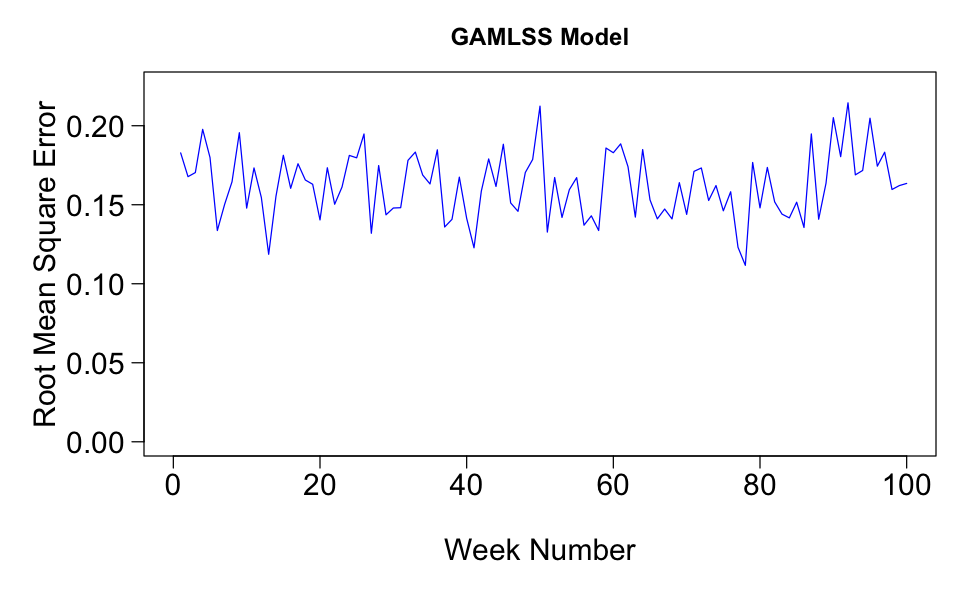

In [193]:
# Compute weekly RMSE, save to file and make a plot.

# Load the training and solution data frames.
rmws              <- 3
nturbines         <- 10
wind_measurements <- c(1, 2, 3, 4, 6, 7, 9, 10)

if (rmws == 3) {
    rm  <- "_rm3_"
    df0 <- read_feather(path="data/Train_pp_2017_03_27_17_46_01.feather")
    df1 <- read_feather(path="data/Solution_pp_2017_04_23_23_11_23.feather")
} else {
    cat("\nData frames for rmws=", rmws, " not available", sep="")
}

# Concatenate the two data frames.
df2 <- rbind(df0, df1)
cat(sprintf("\nData frame df0 dimensions: %6d rows, %3d columns.", dim(df0)[1], dim(df0)[2]))
cat(sprintf("\nData frame df1 dimensions: %6d rows, %3d columns.", dim(df1)[1], dim(df1)[2]))
cat(sprintf("\nData frame df2 dimensions: %6d rows, %3d columns.", dim(df2)[1], dim(df2)[2]))

# Replace wind velocity components by wind velocity magnitudes
U10label  <- paste(paste("U10",  rm, sep=""), 1:nturbines, sep="")
U100label <- paste(paste("U100", rm, sep=""), 1:nturbines, sep="")
V10label  <- paste(paste("V10",  rm, sep=""), 1:nturbines, sep="")
V100label <- paste(paste("V100", rm, sep=""), 1:nturbines, sep="")
H10label  <- paste(paste("H10",  rm, sep=""), 1:nturbines, sep="")
H100label <- paste(paste("H100", rm, sep=""), 1:nturbines, sep="")
for (i in wind_measurements) {
    df2[[H10label[i]]]  <- sqrt(df2[[U10label[i]]]**2  + df2[[V10label[i]]]**2)
    df2[[H100label[i]]] <- sqrt(df2[[U100label[i]]]**2 + df2[[V100label[i]]]**2)
    df2[[U10label[i]]]  <- NULL
    df2[[U100label[i]]] <- NULL
    df2[[V10label[i]]]  <- NULL
    df2[[V100label[i]]] <- NULL
}
cat(sprintf("\nData frame df2 dimensions: %6d rows, %3d columns.\n", dim(df2)[1], dim(df2)[2]))

# Create new data frames, one per turbine output;
predictors <- colnames(df2)[-c(1:10)]
fdf2       <- vector("list", nturbines)
for (i in 1:nturbines) {
    target    <- paste("TARGETVAR_", i, sep="")
    fdf2[[i]] <- df2[, c(target,predictors)]
    nrows0    <- nrow(fdf2[[i]][fdf2[[i]][[target]]==0,])
    nrows1    <- nrow(fdf2[[i]][fdf2[[i]][[target]]==1,])
    cat(sprintf("\nData frame %2d: (%5d, %2d, %4d, %1d);",i,dim(fdf2[[i]])[1],dim(fdf2[[i]])[2],nrows0,nrows1))
}
cat("\n\nLegend: (nrows, ncolumns, nrows(target==0), nrows(target==1))\n")

# Compute predictions
npts            <- dim(df2)[1]
df2_predictions <- vector("double", npts)
for (i in 1:nturbines) {
    prediction      <- paste("PREDICTION_", i, sep="")
    mu_test_pred    <- predict(wtp_full[[i]], what="mu",  newdata=fdf2[[i]], type="response")
    nu_test_pred    <- predict(wtp_full[[i]], what="nu",  newdata=fdf2[[i]], type="response")
    tau_test_pred   <- predict(wtp_full[[i]], what="tau", newdata=fdf2[[i]], type="response")
    p0_test         <- nu_test_pred/(1+nu_test_pred+tau_test_pred)
    p1_test         <- tau_test_pred/(1+nu_test_pred+tau_test_pred)
    p2_test         <- 1 - p0_test - p1_test
    fdf2[[i]][prediction] <- p1_test + p2_test * mu_test_pred
}

# Merge the data frames
df2new <- Reduce(function(dtf1, dtf2) merge(dtf1, dtf2), fdf2)
   
# Add a time stamp to each row in the merged data frame, and remove the YEAR, DAYOFYEAR, and HOUR columns
df2new$TIMESTAMP <- with(df2new, strptime(paste(YEAR, DAYOFYEAR, HOUR), format="%Y %j %H", tz="GMT"))
df2new$YEAR      <- NULL
df2new$DAYOFYEAR <- NULL
df2new$HOUR      <- NULL

# Add a "week number since starting time" to each row
datetime0   <- min(df2new$TIMESTAMP)
df2new$WEEK <- as.numeric(1+(as.integer(difftime(df2new$TIMESTAMP, datetime0, units="hours"))%/%24)%/%7)

# Compute Mean Square Error between target and prediction in each row
df2new$MSE <- with(df2new, ((TARGETVAR_1-PREDICTION_1)^2 + (TARGETVAR_2-PREDICTION_2)^2 + 
                            (TARGETVAR_3-PREDICTION_3)^2 + (TARGETVAR_4-PREDICTION_4)^2 + 
                            (TARGETVAR_5-PREDICTION_5)^2 + (TARGETVAR_6-PREDICTION_6)^2 + 
                            (TARGETVAR_7-PREDICTION_7)^2 + (TARGETVAR_8-PREDICTION_8)^2 + 
                            (TARGETVAR_9-PREDICTION_9)^2 + (TARGETVAR_10-PREDICTION_10)^2)/10)
    
cat(sprintf("\nData frame df2new dimensions: %6d rows, %3d columns.\n", dim(df2new)[1], dim(df2new)[2]))
    
# Compute Root Mean Square Error by week
rmse_byweek <- aggregate(MSE ~ WEEK, df2new, mean)
rmse_byweek$RMSE <- with(rmse_byweek, sqrt(MSE))
rmse_byweek$MSE <- NULL

# Write results to file
write.table(matrix(rmse_byweek$RMSE, nrow=1), file="data/gamr_weekly_rmse.csv", 
            col.names=FALSE, row.names=FALSE, sep=",")
    
# Make plot
options(repr.plot.width=8, repr.plot.height=5)
par(mgp=c(3, 1, 0), mar=c(6,6,3,1), mfrow=c(1, 1))
main_title <- paste("GAMLSS Model")
plot(rmse_byweek$WEEK, rmse_byweek$RMSE, type="l", col="blue", main=main_title,
     xlab="Week Number", ylab="Root Mean Square Error", xlim=c(0.0, 100.0), ylim=c(0.0, 0.225),
     cex.lab=1.5, cex.axis=1.5, mgp=c(3.5,0.8,0), las=1)